In [1]:
from PIL import Image
import os
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from transformers import pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

In [44]:
classifier1 = pipeline("image-classification", model="NYUAD-ComNets/NYUAD_AI-generated_images_detector")
classifier2 = pipeline("image-classification", model="haywoodsloan/ai-image-detector-deploy")

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Device set to use cuda:0
Device set to use cuda:0


In [46]:
def postprocess(model_output, id2label = {"real": 0, "sd": 1, "dalle": 1, "artificial": 1}):
    scores = [label_dict["score"] for label_dict in model_output]
    labels = [id2label[label_dict["label"]] for label_dict in model_output]
    predict = labels[np.argmax(scores)]
    return predict, max(scores)

In [53]:
base_path = "../data"

for test_dataset in sorted(os.listdir(base_path)):
    all_preds, all_targets, all_scores = [[], []], [[], []], [[], []]
    print(f"Start process {test_dataset}")
    test_csv = pd.read_csv(os.path.join(base_path, test_dataset, "test.csv"))
    for _, row in tqdm(test_csv.iterrows(), total=len(test_csv)):
        filepath = row["image_path"] if row["image_path"][0] == "/" else os.path.join(base_path, test_dataset, row["image_path"])
        image = Image.open(filepath)
        for i, classifier in enumerate([classifier1, classifier2]):
            pred = classifier(image)
            predict_lbl, score = postprocess(pred)
            all_preds[i].append(predict_lbl)
            all_targets[i].append(row["label"])
            all_scores[i].append(score)

    for i in range(2):
        df = pd.DataFrame({
                "label": all_targets[i],
                "predicted_raw": all_preds[i],
                "scores": all_scores[i],
            })
        df.to_csv(f"../results/open_models/model_hf{i+1}/data_{test_dataset}/predictions.csv", index=False)

Start process aiVShuman


100%|██████████| 7995/7995 [04:56<00:00, 26.99it/s]


Start process artifact


100%|██████████| 1200/1200 [00:36<00:00, 32.58it/s]


Start process defactify


100%|██████████| 4236/4236 [02:49<00:00, 25.02it/s]


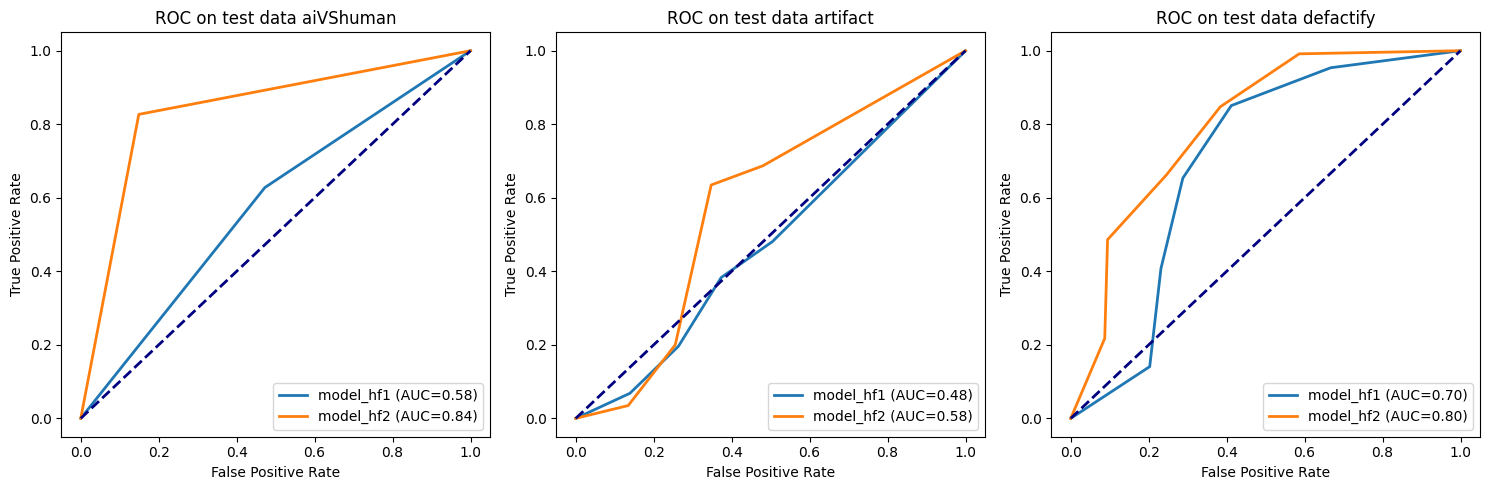


Performance Metrics:
Full Model Name Model   Test Dataset  ROC-AUC  Precision@Recall≥0.3  Precision@Recall≥0.5  Precision@Recall≥0.7
            hf1   hf1 data_aiVShuman     0.58                  0.22                  0.22                  0.18
            hf2   hf2 data_aiVShuman     0.84                  0.86                  0.86                  0.86
            hf1   hf1  data_artifact     0.48                  0.20                  0.20                  0.20
            hf2   hf2  data_artifact     0.58                  0.16                  0.16                  0.10
            hf1   hf1 data_defactify     0.70                  0.76                  0.76                  0.74
            hf2   hf2 data_defactify     0.80                  0.89                  0.81                  0.78

Best Models for Each Test Dataset:
Full Model Name Model   Test Dataset  ROC-AUC  Precision@Recall≥0.3  Precision@Recall≥0.5  Precision@Recall≥0.7
            hf2   hf2 data_aiVShuman     0.84 

In [5]:
results_path = "../results/open_models"
test_datasets = sorted(os.listdir(os.path.join(results_path, sorted(os.listdir(results_path))[0])))

metrics_data = []

fig, axes = plt.subplots(1, len(test_datasets), figsize=(5*len(test_datasets), 5))

for idx, test_data in enumerate(test_datasets):
    ax = axes[idx]
    ax.set_title(f"ROC on test {test_data.replace('_', ' ')}")
    
    for result_folder in sorted(os.listdir(results_path)):
        predictions = pd.read_csv(os.path.join(results_path, result_folder, test_data, "predictions.csv"))
        scores = predictions["label"].values
        y_true = predictions["predicted_raw"].values
        y_true = [0 if y == 0 else 1 for y in y_true]
        
        fpr, tpr, thresholds = roc_curve(y_true, scores)
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, lw=2, label=f'{result_folder} (AUC={roc_auc:.2f})')
        
        precision, recall, _ = precision_recall_curve(y_true, scores)
        
        def get_precision_at_recall(recall_level):
            mask = recall >= recall_level
            if any(mask):
                return np.max(precision[mask])
            return np.nan
        
        prec_at_recall_03 = get_precision_at_recall(0.3)
        prec_at_recall_05 = get_precision_at_recall(0.5)
        prec_at_recall_07 = get_precision_at_recall(0.7)
        
        # Извлекаем информацию о модели из названия папки
        model_parts = result_folder.split('_')
        model_name = model_parts[1]
        
        # Добавляем метрики в список
        metrics_data.append({
            'Model': model_name,
            'Test Dataset': test_data,
            'ROC-AUC': round(roc_auc, 2),
            'Precision@Recall≥0.3': round(prec_at_recall_03, 2),
            'Precision@Recall≥0.5': round(prec_at_recall_05, 2),
            'Precision@Recall≥0.7': round(prec_at_recall_07, 2)
        })
    
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")

metrics_df = pd.DataFrame(metrics_data)

metrics_df['Full Model Name'] = metrics_df.apply(
    lambda row: f"{row['Model']}", axis=1
)

metrics_df = metrics_df[[
    'Full Model Name', 'Model', 'Test Dataset',
    'ROC-AUC', 'Precision@Recall≥0.3', 'Precision@Recall≥0.5', 'Precision@Recall≥0.7'
]]

plt.tight_layout()
#plt.savefig(os.path.join(results_path, "all_roc_curves.png"), dpi=300, bbox_inches='tight')
plt.show()

# metrics_df.to_csv(os.path.join(results_path, "performance_metrics_detailed.csv"), index=False)

print("\nPerformance Metrics:")
print(metrics_df.to_string(index=False))

best_models = metrics_df.loc[metrics_df.groupby('Test Dataset')['ROC-AUC'].idxmax()]
print("\nBest Models for Each Test Dataset:")
print(best_models.to_string(index=False))